# Using Landlab and PyGMT Together to Create Interactive Erosion Slider

As we have seen, we can use Landlab and PyGMT together to download data, convert to and from PyGMT to Landlab, and  visualize our output using PyGMT plotting functions. Expanding on our usage of Landlab and PyGMT, in this tutorial we will explore:

- PyGMT Visualizations:
    - DEM data visualized with grdimage for realistic mapping.
    
- Flow Path Overlay:
    - Threshold-based flow path extraction, visualized with <code>pygmt.plot</code>.
    
- Interactive Modeling:
    - Users can adjust the erodibility factor (K_sp) and observe terrain evolution in real-time with PyGMT maps.

## Required packages:
- Numpy
- PyGMT
- Landlab

We will begin by importing the following packages

In [78]:
import numpy as np
import pygmt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, DepressionFinderAndRouter
from ipywidgets import interact, FloatSlider
import xarray as xr

We will begin using the <code>RasterModelGrid</code> function from Landlab to create our grid

In [79]:
# Define grid size and node spacing
ncols, nrows = 100, 100
dx = 0.01

# Create a raster grid
mg = RasterModelGrid((nrows, ncols), xy_spacing=dx)

Then, loading DEM data from PyGMT. In this example we will use topographic elevation data.

In [80]:
# Load DEM data
z = mg.add_field(
    "topographic__elevation",
    np.random.rand(mg.number_of_nodes) * 1000,
    at="node"
)

To make the terrain more realistic, we will use <code>np.random.rand</code> to apply random pertubations to our data

In [81]:
z = z.reshape(nrows, ncols)  # Reshape z before addition
z += np.random.rand(nrows, ncols) * 50

We can visualize this data by using <code>Figure</code> and <code>grdimage</code>

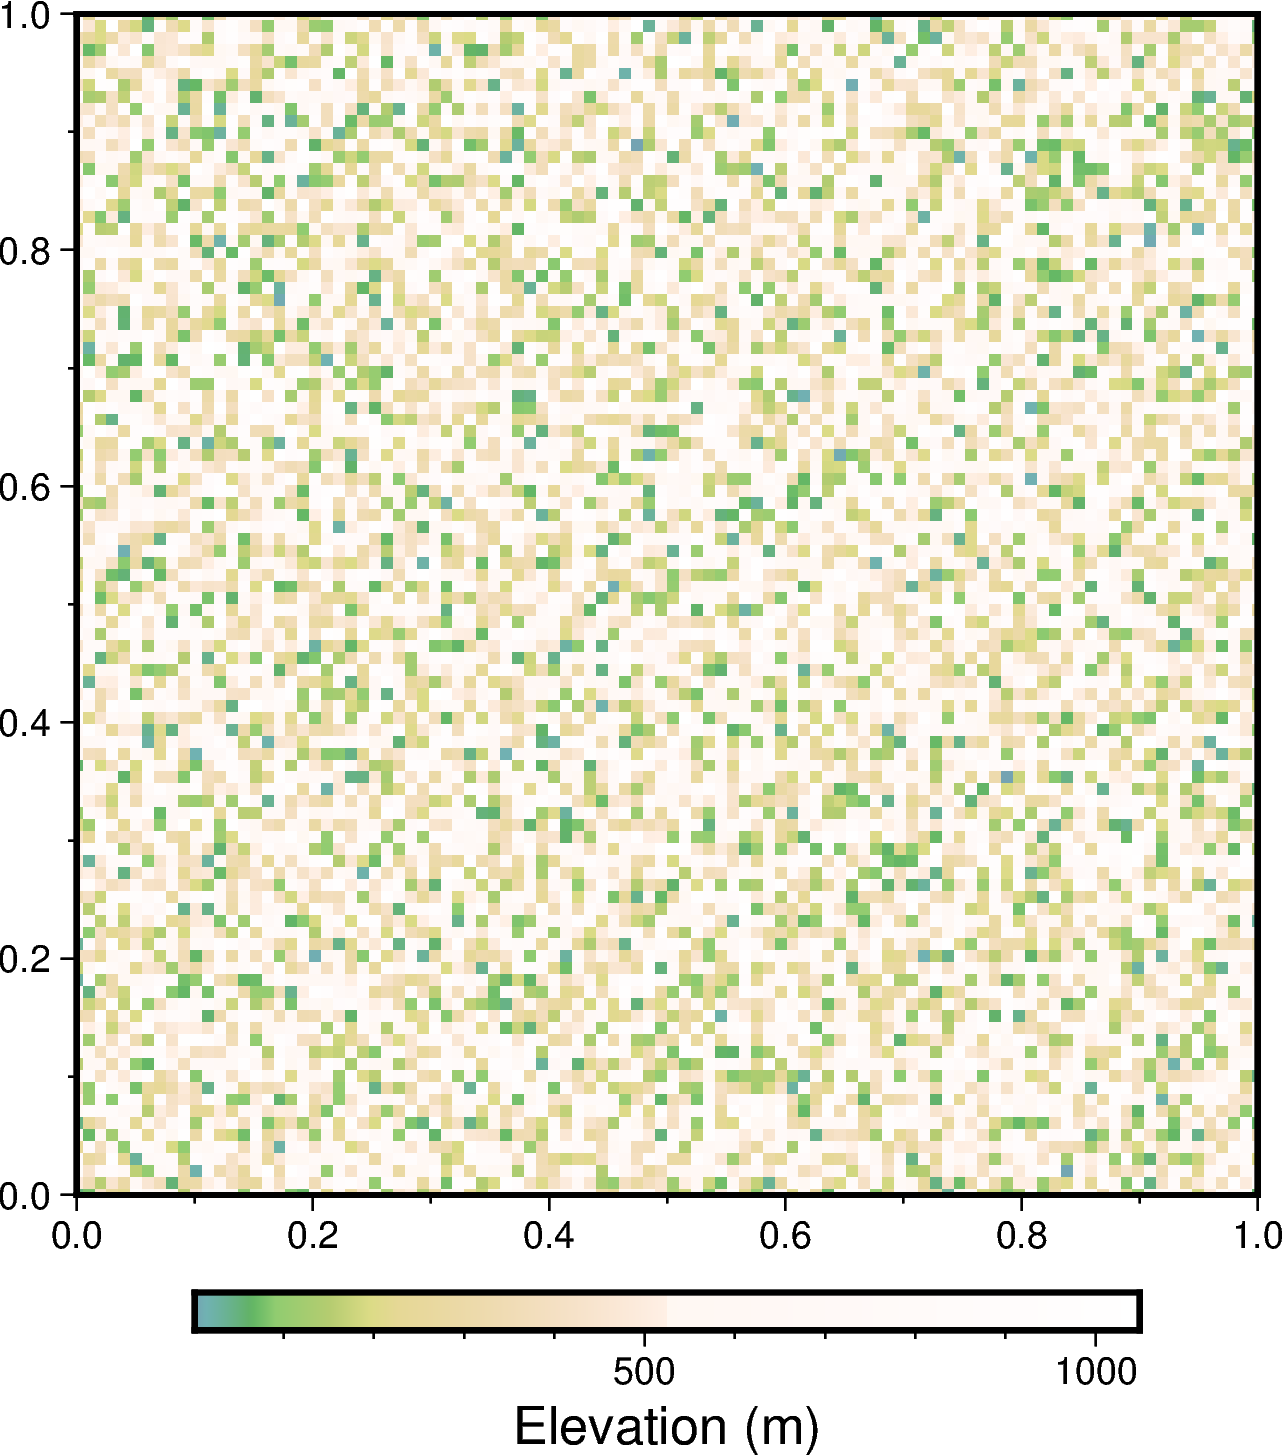

In [82]:
# Convert numpy array to xarray.DataArray with coordinates
region = [0, z.shape[1] * dx, 0, z.shape[0] * dx]
grid = xr.DataArray(
    z,
    coords={
        "lon": np.linspace(region[0], region[1], z.shape[1]),
        "lat": np.linspace(region[2], region[3], z.shape[0])
    },
    dims=["lat", "lon"],
)

# Create a figure and plot the grid
fig = pygmt.Figure()
fig.grdimage(
    grid=grid,
    region=region,
    projection="X10c/10c",
    cmap="topo",
    frame=True
)
fig.colorbar(frame="af+lElevation (m)")
fig.show()

Next, we will create the elements we need to visualize the drainage area

In [83]:
# Initialize flow routing and depression filling
fa = FlowAccumulator(mg)
df = DepressionFinderAndRouter(mg)

# Run flow routing and depression filling
fa.run_one_step()
df.map_depressions()

# Ensure 'drainage_area' is present
drainage_area = mg.at_node["drainage_area"]

Extracting drainage and elevation area and reshaping them into 2D array

Now, visualizing drainage area

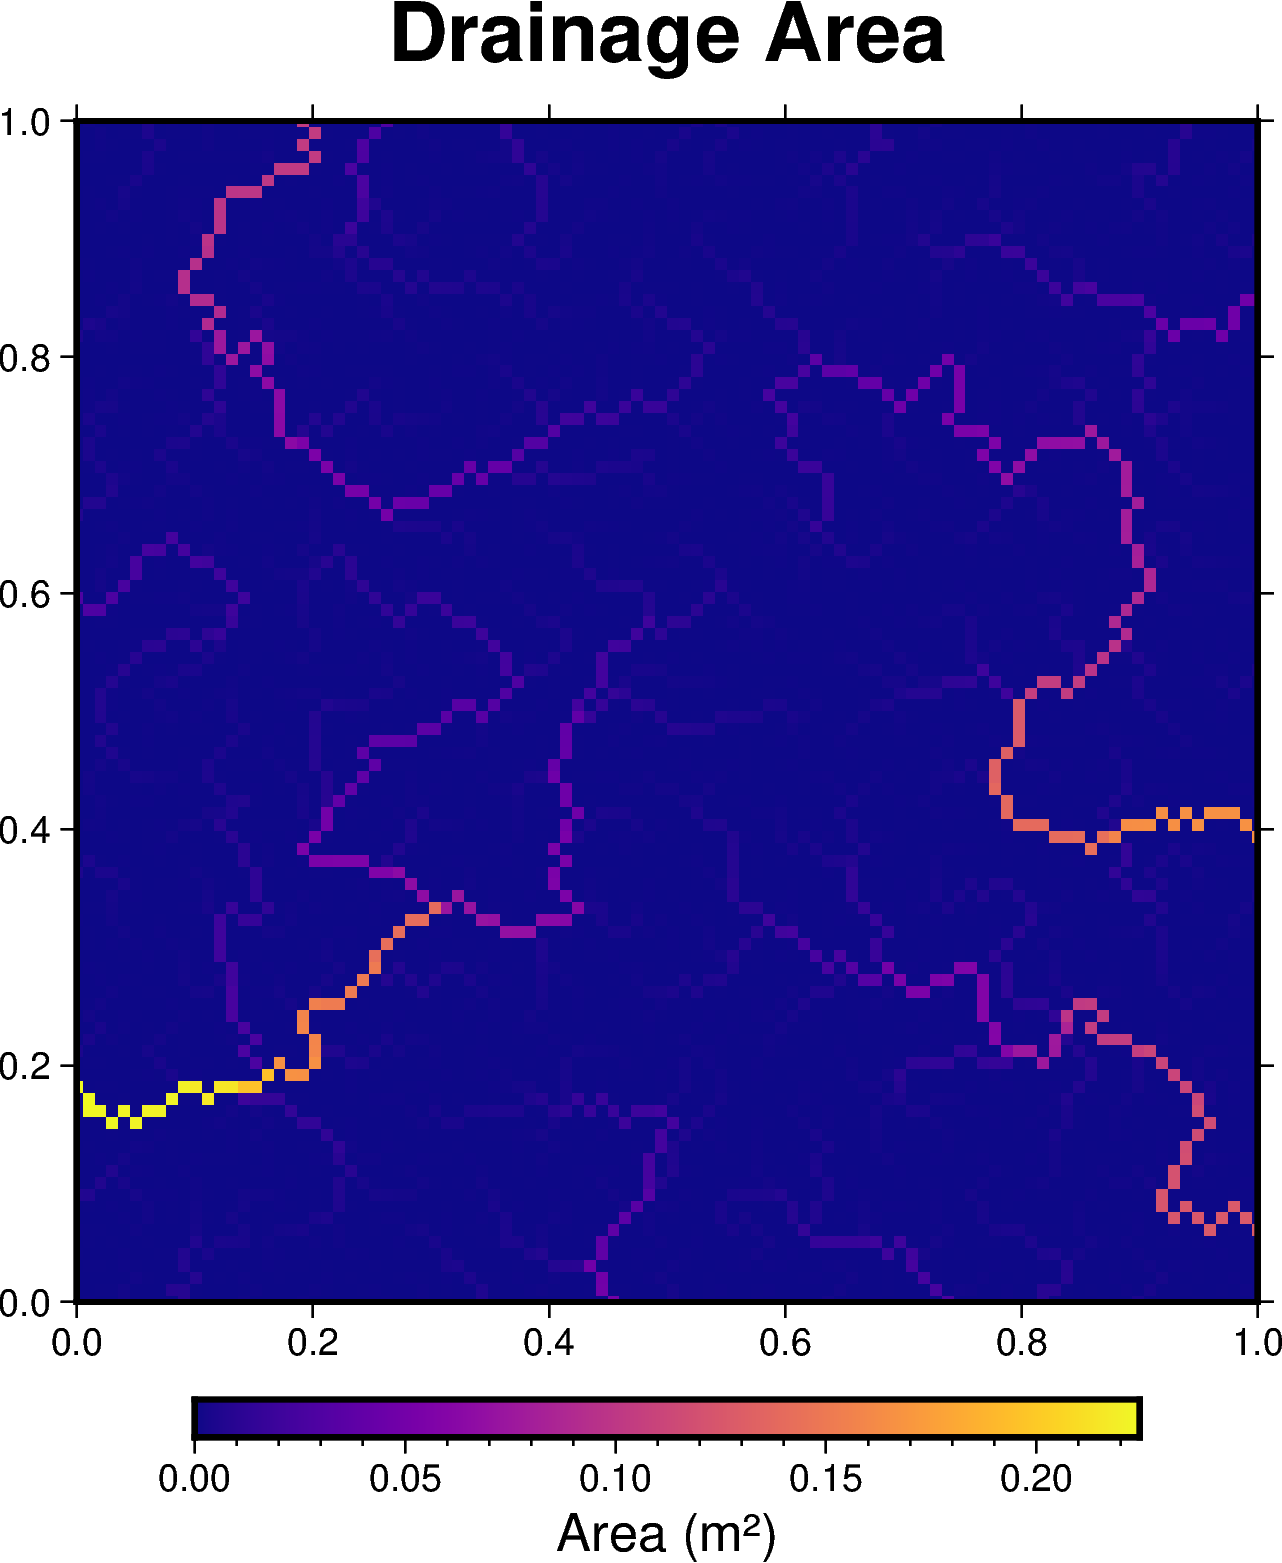

In [84]:
# Convert drainage area to xarray.DataArray
drainage_area_grid = xr.DataArray(
    drainage_area.reshape((nrows, ncols)),
    coords={
        "lon": np.linspace(region[0], region[1], ncols),
        "lat": np.linspace(region[2], region[3], nrows),
    },
    dims=["lat", "lon"],
)

# Visualize drainage area
fig = pygmt.Figure()
fig.grdimage(
    grid=drainage_area_grid,
    region=region,
    projection="X10c/10c",
    cmap="plasma",
    frame=["a", "WSen+tDrainage Area"]
)
fig.colorbar(frame="af+lArea (m²)")
fig.show()

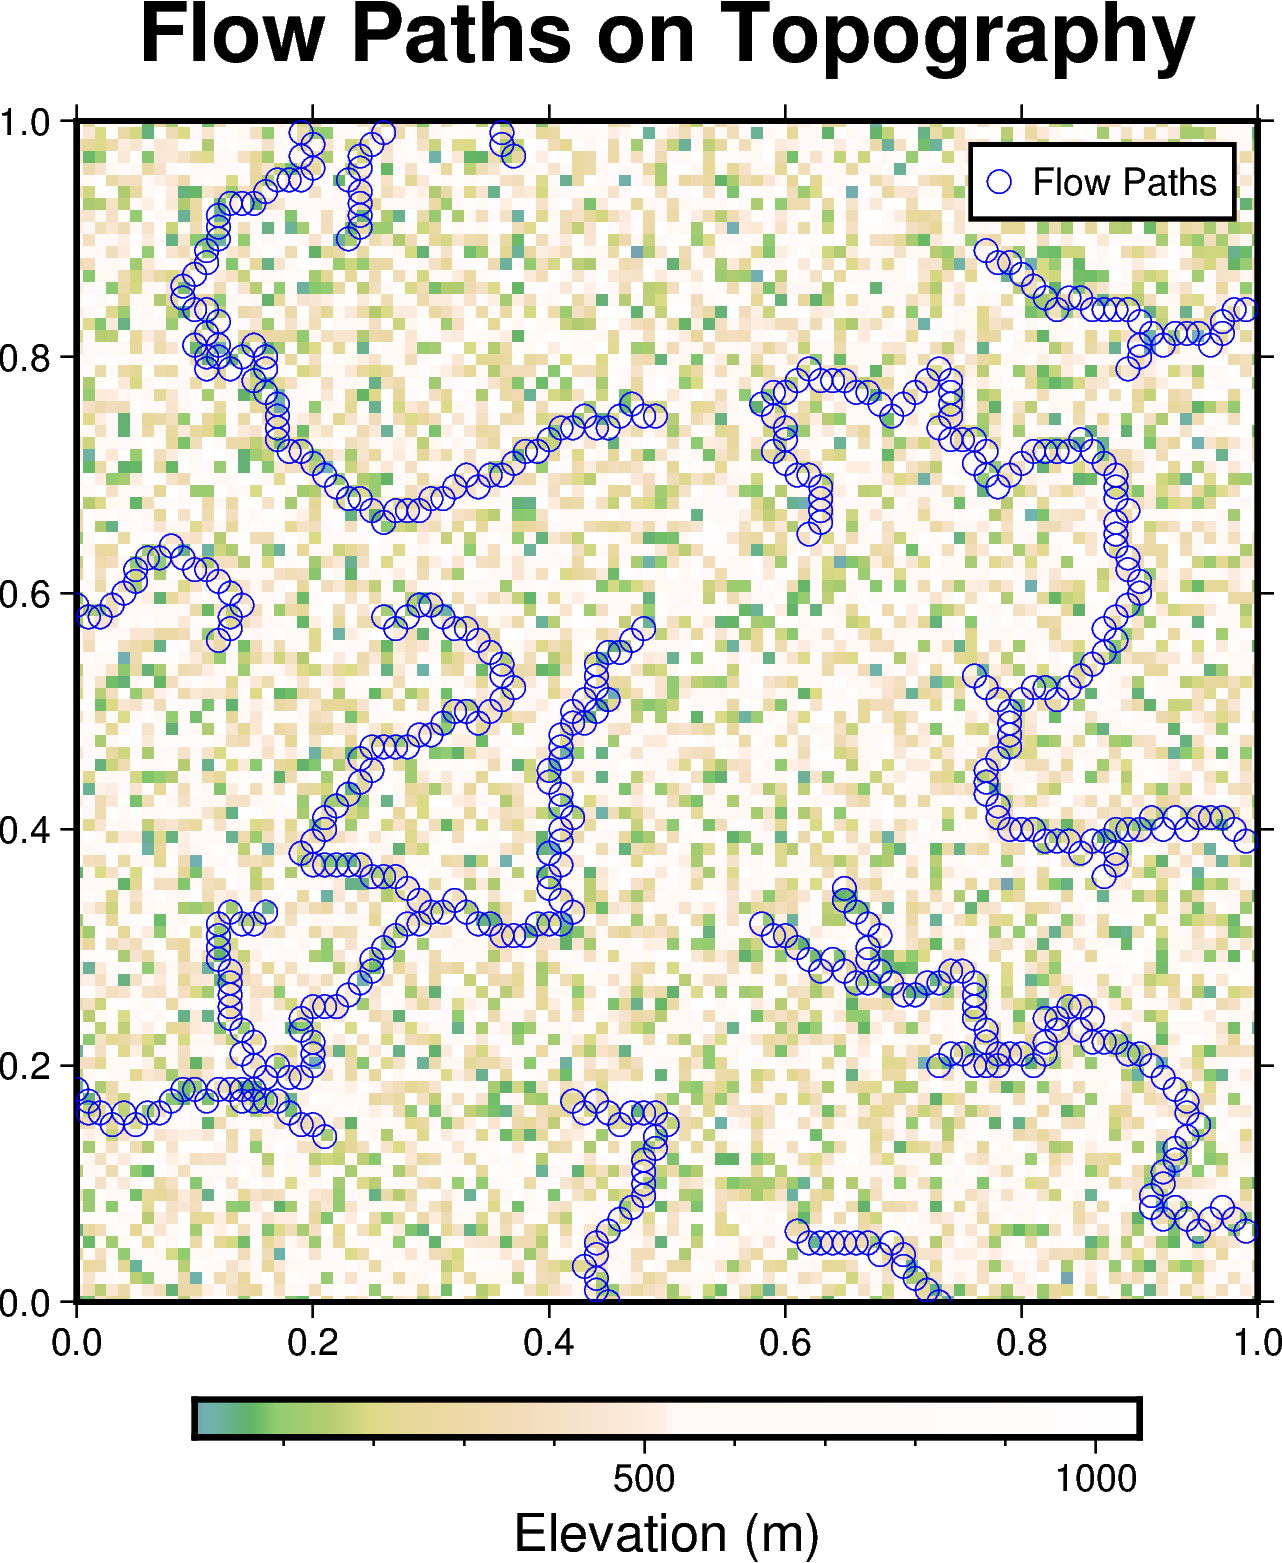

In [85]:
# Define top 5% of drainage area as major streams
threshold = np.percentile(drainage_area, 95)
stream_nodes = drainage_area > threshold

# Extract node coordinates for flow paths
stream_x, stream_y = mg.node_x[stream_nodes], mg.node_y[stream_nodes]

# Convert 'filled_elevation' to xarray.DataArray for visualization
filled_elevation = mg.at_node["topographic__elevation"].reshape((nrows, ncols))
filled_elevation_grid = xr.DataArray(
    filled_elevation,
    coords={
        "lon": np.linspace(region[0], region[1], ncols),
        "lat": np.linspace(region[2], region[3], nrows),
    },
    dims=["lat", "lon"],
)

# Visualize flow paths on topography
fig = pygmt.Figure()
fig.grdimage(
    grid=filled_elevation_grid,
    region=region,
    projection="X10c/10c",
    cmap="topo",
    frame=["a", "WSen+tFlow Paths on Topography"]
)
fig.plot(
    x=stream_x, y=stream_y, style="c0.2c", pen="blue", label="Flow Paths"
)
fig.legend()
fig.colorbar(frame="af+lElevation (m)")
fig.show()

For interactive modeling, we will define our function <code>run_erosion</code>. Passing through the erodability factor <code>K_sp</code>, this function will provide us visualization of different values of <code>K_sp</code> on erosion.

In [86]:
# Interactive erosion modeling function
def run_erosion(K_sp):
    # Reset DEM to original state
    mg.at_node["topographic__elevation"][:] = z.flatten()

    # Define constants
    uplift_rate = 0.1  # Tectonic lift rate
    n_steps = 50  # Number of steps

    for _ in range(n_steps):
        mg.at_node["topographic__elevation"][mg.core_nodes] += uplift_rate
        fa.run_one_step()
        mg.at_node["topographic__elevation"][mg.core_nodes] -= (
            10 * K_sp * mg.at_node["drainage_area"][mg.core_nodes]
        )

    # Plot eroded terrain
    eroded_elevation = mg.at_node["topographic__elevation"].reshape((nrows, ncols))
    eroded_elevation_grid = xr.DataArray(
        eroded_elevation * 10,
        coords={
            "lon": np.linspace(region[0], region[1], ncols),
            "lat": np.linspace(region[2], region[3], nrows),
        },
        dims=["lat", "lon"],
    )

    fig = pygmt.Figure()
    fig.grdimage(
        grid=eroded_elevation_grid,
        region=region,
        projection="X10c/10c",
        cmap="plasma",
        frame=["a", f"WSen+tEroded Topography (K_sp={K_sp})"]
    )
    fig.colorbar(frame="af+lElevation (m)")
    fig.show()


Run <code>run_ersion</code> and visualize results

In [87]:
# Add interactive slider for erosion modeling
interact(
    run_erosion,
    K_sp=FloatSlider(value=1e-3, min=1e-5, max=1e-2, step=1e-4, description="K_sp"),
)

interactive(children=(FloatSlider(value=0.001, description='K_sp', max=0.01, min=1e-05, step=0.0001), Output()…

<function __main__.run_erosion(K_sp)>